### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import os

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Fix seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed=42
seed_everything(seed) # Seed 고정

### Load df

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = df_train.drop(['ID'],axis=1)
df_test = df_test.drop(['ID'],axis=1)
df_test.fillna('NAN',inplace=True)
df_train = df_train.drop_duplicates()

### Check outlier about Income

<Axes: ylabel='Income'>

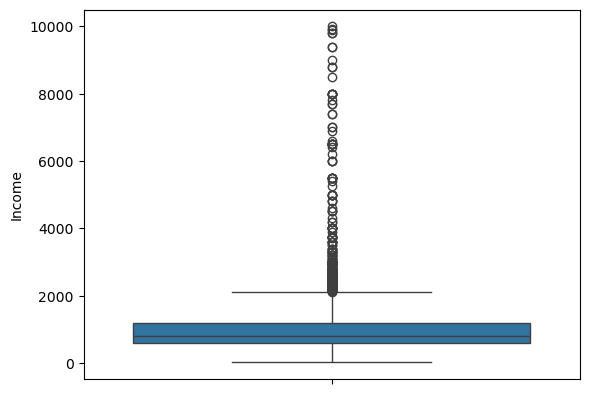

In [4]:
sns.boxplot(df_train[df_train['Income']>0]['Income'])

### EDA

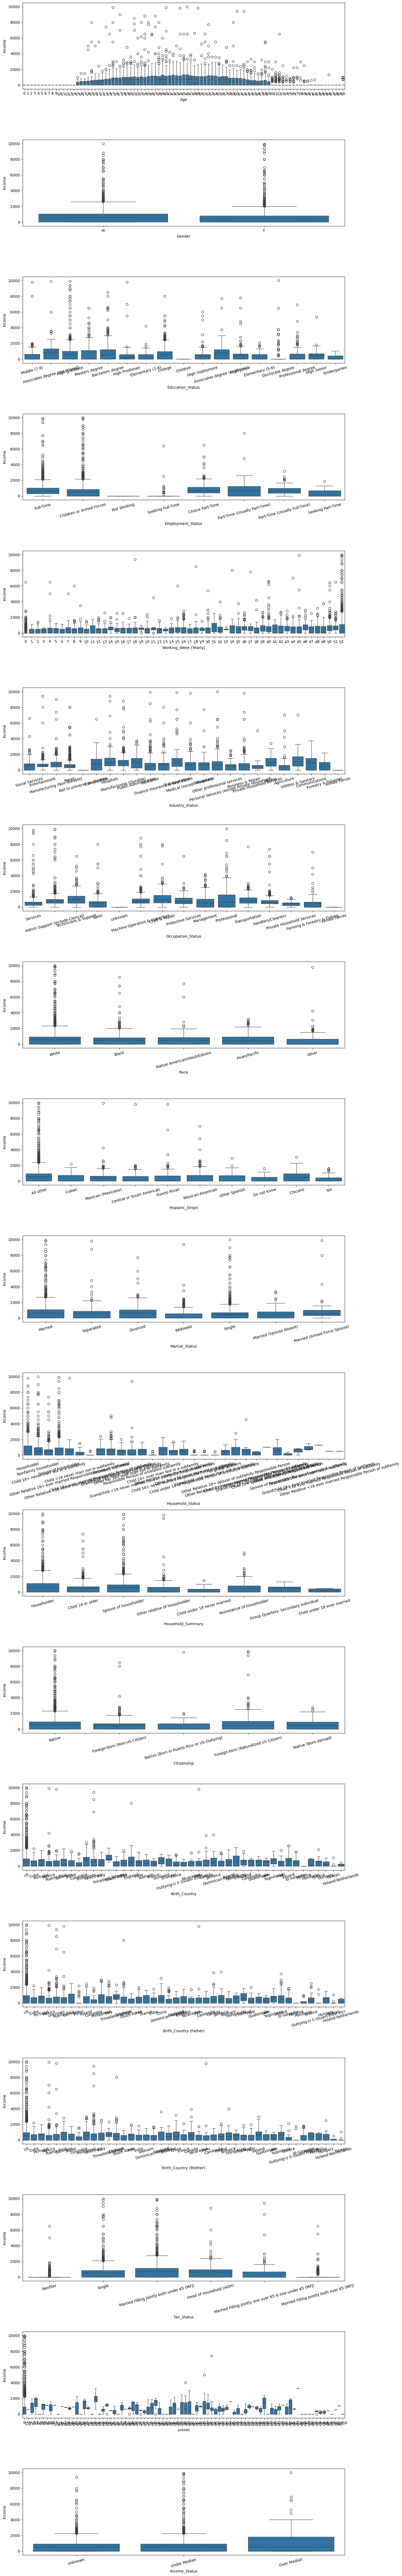

In [5]:

selected_cols = [col for col in df_train.columns if len(df_train[col].unique()) <= 100]
# target과의 관계를 살펴보기 위해, target을 분리하여 데이터를 분석
train_eda = df_train[selected_cols + ['Income']].copy()

plt.figure(figsize=(15, 100))
for i, col in enumerate(selected_cols):
    plt.subplot(20, 1, i+1)
    sns.boxplot(x=col, y='Income', data=train_eda)
    plt.xticks(rotation=15)
    plt.tight_layout()

### preprocessing

In [6]:
df_train = df_train[df_train['Industry_Status']!='Not in universe or children']
df_train = df_train[df_train['Age']>14]
df_train = df_train[df_train['Education_Status']!='Children']
df_train = df_train[df_train['Employment_Status']!='Not Working']
df_train = df_train[df_train['Occupation_Status']!='Unknown']
df_train = df_train[df_train['Income']<6000]

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15231 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     15231 non-null  int64 
 1   Gender                  15231 non-null  object
 2   Education_Status        15231 non-null  object
 3   Employment_Status       15231 non-null  object
 4   Working_Week (Yearly)   15231 non-null  int64 
 5   Industry_Status         15231 non-null  object
 6   Occupation_Status       15231 non-null  object
 7   Race                    15231 non-null  object
 8   Hispanic_Origin         15231 non-null  object
 9   Martial_Status          15231 non-null  object
 10  Household_Status        15231 non-null  object
 11  Household_Summary       15231 non-null  object
 12  Citizenship             15231 non-null  object
 13  Birth_Country           15231 non-null  object
 14  Birth_Country (Father)  15231 non-null  object
 15  Birth_C

<Axes: xlabel='Income', ylabel='Count'>

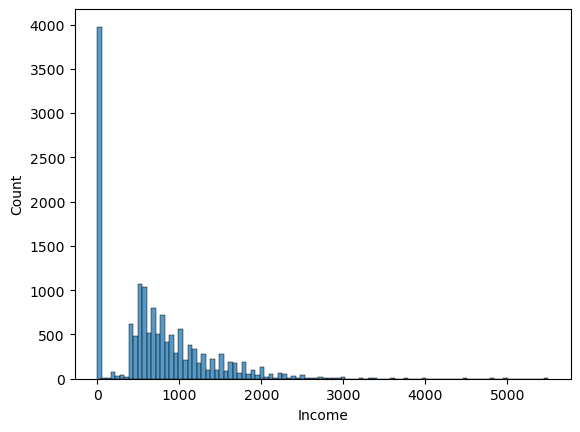

In [7]:
sns.histplot(df_train['Income'],bins=100)

### object to category

In [8]:
categorical_features = list(df_train.dtypes[df_train.dtypes=='object'].index)

for i in categorical_features:
    df_train[i] = df_train[i].astype('category')
    df_test[i] = df_test[i].astype('category')

x_train = df_train.drop('Income', axis=1)
y_train = df_train['Income']

### Train LGBM

In [9]:
params = {
    'lambda_l1': 0.02376856687184958,
    'lambda_l2': 1.2645848339107883e-08,
    'num_leaves': 31,
    'learning_rate': 0.03373139521340064,
    'feature_fraction': 0.8234703314292054,
    'bagging_fraction': 0.8205263711474302,
    'bagging_freq': 1,
    'min_child_samples': 39,
    }

In [10]:
model = lgb.LGBMRegressor(**params)
model.fit(x_train,y_train)

[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: baggin

LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

### Predict

In [11]:
pred = model.predict(df_test)
pred = np.where(df_test['Industry_Status']=='Not in universe or children',0,pred)
pred = np.where(df_test['Age']<15,0,pred)
pred = np.where(df_test['Education_Status']=='Children',0,pred)
pred = np.where(df_test['Employment_Status']=='Not Working',0,pred)
pred = np.where(df_test['Occupation_Status']=='Unknown',0,pred)
pred = [0 if i < 150 else i for i in pred]

[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08


### submit

In [12]:
df_submit = pd.read_csv('sample_submission.csv')
df_submit['Income'] = pred

In [13]:
df_submit.to_csv("submission.csv", index=False)